In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from matplotlib import pyplot as plt

from counterfactuals.datasets import CreditDefaultDataset
from counterfactuals.losses import BinaryDiscLoss
from counterfactuals.cf_methods.group_ppcef.rppcef import RPPCEF
from counterfactuals.generative_models import MaskedAutoregressiveFlow
from counterfactuals.discriminative_models import MultilayerPerceptron
from counterfactuals.metrics import CFMetrics

/Users/oleksiifurman/Developer/counterfactuals/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = CreditDefaultDataset("../data/credit_default.csv", shuffle=False)

In [4]:
# df = dataset.raw_data
# df = pd.DataFrame(dataset.X_train, columns=df.columns[:-1])
# df["default payment next month"] = dataset.y_train

# import seaborn as sns

# # Display basic information about the dataframe
# print(df.info())

# # Display basic statistics of the dataframe
# print(df.describe())

# # Check for missing values
# print(df.isnull().sum())

# # Plot the distribution of the target variable
# plt.figure(figsize=(10, 6))
# sns.countplot(x='default payment next month', data=df)
# plt.title('Distribution of Default Payment Next Month')
# plt.show()

# # Plot the correlation matrix
# plt.figure(figsize=(15, 10))
# correlation_matrix = df.corr()
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
# plt.title('Correlation Matrix')
# plt.show()

# # Plot the distribution of numerical features
# df.hist(bins=30, figsize=(20, 15), layout=(8, 3))
# plt.tight_layout()
# plt.show()

# # Plot pairplot for a subset of features
# subset_features = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'PAY_AMT1', 'default payment next month']
# sns.pairplot(df[subset_features], hue='default payment next month')
# plt.show()

In [5]:
# x_res = dataset.feature_transformer["cat"].inverse_transform(dataset.X_train[:, dataset.categorical_columns])

In [6]:
disc_model = MultilayerPerceptron(dataset.X_test.shape[1], [128, 128], 1, dropout=0.3)
disc_model.fit(
    dataset.train_dataloader(batch_size=256, shuffle=True),
    dataset.test_dataloader(batch_size=256, shuffle=False),
    epochs=5000,
    patience=100,
    lr=1e-3,
    checkpoint_path="disc_model.pt",
)
# disc_model.load("heloc_disc_model.pt")

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/oleksiifurman/Developer/counterfactuals/counterfactuals/discriminative_models/multilayer_perceptron.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to t

In [7]:
# disc_model = LogisticRegression(dataset.X_test.shape[1], 1)
# disc_model.fit(
#     dataset.train_dataloader(batch_size=256, shuffle=True),
#     dataset.test_dataloader(batch_size=256, shuffle=False),
#     epochs=5000,
#     patience=100,
#     checkpoint_path="disc_model.pt",
# )
# # # disc_model.load("disc_model.pt")

In [8]:
disc_model.eval()
y_pred = disc_model.predict(dataset.X_test).detach().numpy().flatten()
print("Test accuracy:", (y_pred == dataset.y_test).mean())

Test accuracy: 0.8277044402537288


In [9]:
dataset.y_train = disc_model.predict(dataset.X_train).detach().numpy()
dataset.y_test = disc_model.predict(dataset.X_test).detach().numpy()

In [ ]:
gen_model = MaskedAutoregressiveFlow(
    features=dataset.X_train.shape[1],
    hidden_features=32,
    num_blocks_per_layer=2,
    num_layers=5,
    context_features=1,
    batch_norm_within_layers=True,
    batch_norm_between_layers=True,
    use_random_permutations=True,
)
train_dataloader = dataset.train_dataloader(
    batch_size=256, shuffle=True, noise_lvl=0.03
)
test_dataloader = dataset.test_dataloader(batch_size=256, shuffle=False)

gen_model.fit(
    train_dataloader,
    train_dataloader,
    learning_rate=1e-3,
    patience=100,
    num_epochs=1000,
    checkpoint_path="credit_default_flow.pt",
)
# gen_model.load("credit_default_flow.pt")

Epoch 499, Train: 0.4055, test: 0.4056, patience: 2: 100%|██████████| 500/500 [11:22<00:00,  1.37s/it] 
/Users/oleksiifurman/Developer/counterfactuals/counterfactuals/generative_models/maf/maf.py:163: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open 

In [22]:
dataset.X[:, :3]

array([[ 20000,      1,      1],
       [120000,      1,      1],
       [ 90000,      1,      1],
       ...,
       [ 30000,      0,      1],
       [ 80000,      0,      2],
       [ 50000,      0,      1]])

In [23]:
dataset.X_test[:, :3]

array([[-1.1303681 , -1.4678429 ,  1.4544897 ],
       [-0.28055307, -0.09865116,  0.40045395],
       [-0.04878536, -0.54942757,  0.12739141],
       ...,
       [-1.0531121 , -0.00755102,  0.39872003],
       [-0.66683257, -1.1677203 ,  2.5451603 ],
       [-0.8986003 , -0.37212133, -0.19348139]], dtype=float32)

In [ ]:
dataset.inverse_transform(dataset.X_train[:, 1:3], dataset.categorical_columns)

In [14]:
source_class = 0
target_class = 1
X_test_origin = dataset.X_test[dataset.y_test == source_class]
y_test_origin = dataset.y_test[dataset.y_test == source_class]

In [15]:
dataset.not_actionable_features = [
    i
    for i in range(len(dataset.feature_columns))
    if i not in dataset.actionable_features
]
cf_method = RPPCEF(
    X=X_test_origin,
    cf_method_type="GCE",
    K=3,
    gen_model=gen_model,
    disc_model=disc_model,
    disc_model_criterion=BinaryDiscLoss(),
    # actionable_features=None,
    # TODO: poprawa nazewnictwa
    actionable_features=dataset.not_actionable_features,
    neptune_run=None,
)

train_dataloader_for_log_prob = dataset.train_dataloader(batch_size=4096, shuffle=False)
log_prob_threshold = torch.quantile(
    gen_model.predict_log_prob(train_dataloader_for_log_prob),
    0.1,
)

cf_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(X_test_origin).float(),
        torch.tensor(y_test_origin).float(),
    ),
    batch_size=4096,
    shuffle=False,
)


delta, Xs, ys_orig, ys_target = cf_method.explain_dataloader(
    dataloader=cf_dataloader,
    epochs=20000,
    lr=1e-3,
    patience=1000,
    alpha_dist=1e-2,
    alpha_plaus=10**4,
    alpha_class=10**5,
    alpha_s=10**2,
    alpha_k=10**2,
    log_prob_threshold=log_prob_threshold,
)

M, S, D = delta.get_matrices()
Xs_cfs = Xs + delta().detach().numpy()

values, indexes = S.max(dim=1)

total = len(values)
i_correct = indexes[values == 1]
print(f"Correct: {len(i_correct)}/{total}")
print(len(set(i_correct.tolist())))

loss: 41275.0391, dist: 0.0356, max_inner: 8771.2539, loss_disc: 32477.5215, delta_loss: 26.2648: 100%|██████████| 20000/20000 [03:22<00:00, 99.00it/s]  


Correct: 335/643
3


In [16]:
metrics = CFMetrics(
    X_cf=Xs_cfs,
    y_target=ys_target,
    X_train=dataset.X_train,
    y_train=dataset.y_train,
    X_test=X_test_origin,
    y_test=y_test_origin,
    disc_model=disc_model,
    gen_model=gen_model,
    continuous_features=dataset.numerical_features,
    categorical_features=dataset.categorical_features,
    prob_plausibility_threshold=log_prob_threshold,
)
metrics.calc_all_metrics()

{'coverage': 1.0,
 'validity': 0.7558320373250389,
 'actionability': 0.0,
 'sparsity': 0.2608695652173913,
 'proximity_categorical_hamming': 0.9696066634530872,
 'proximity_categorical_jaccard': 0.9696066634530872,
 'proximity_continuous_manhattan': 1.4058448717164793,
 'proximity_continuous_euclidean': 0.9696066634530872,
 'proximity_continuous_mad': 10.902070196765036,
 'proximity_l2_jaccard': 0.9696066634530872,
 'proximity_mad_hamming': 10.902070196765036,
 'prob_plausibility': 0.6936236391912908,
 'log_density_cf': -19.389416,
 'log_density_test': -5.6161857,
 'lof_scores_cf': 1.3251867,
 'lof_scores_test': 1.1561751,
 'isolation_forest_scores_cf': 0.06668561771103282,
 'isolation_forest_scores_test': 0.08938563744080388}

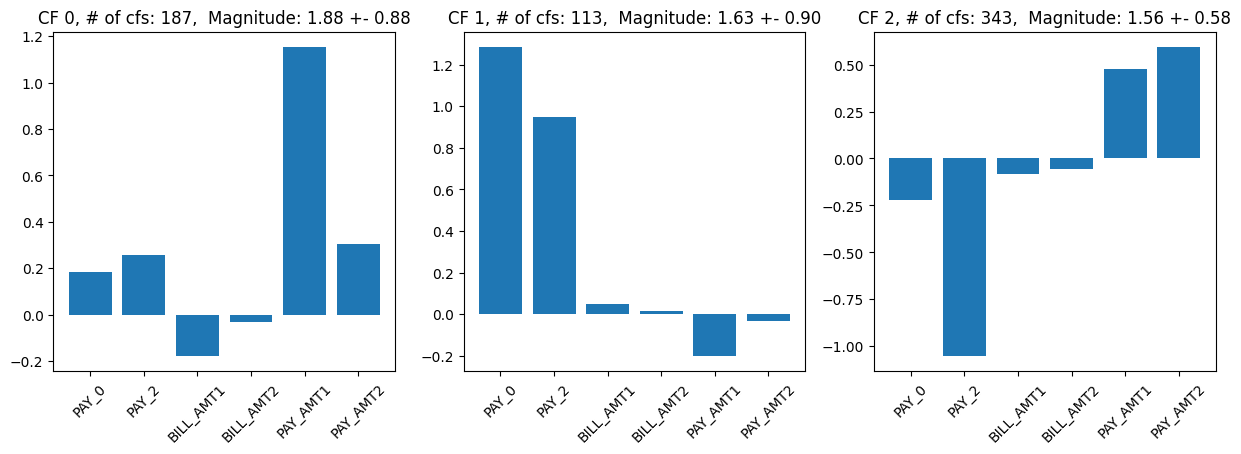

In [25]:
plt.figure(figsize=(15, 15))

groups = S.argmax(dim=1)

for i in range(D.shape[0]):
    plt.subplot(3, 3, i + 1)
    plt.bar(
        range(len(dataset.actionable_features)),
        D[i, dataset.actionable_features].detach().numpy(),
    )
    mean_magn = M.squeeze()[groups == i].mean(axis=0)
    std_magn = M.squeeze()[groups == i].std(axis=0)
    n_vectors = (S.argmax(axis=1) == i).sum()
    feature_names = dataset.feature_columns
    # add feature names to plot
    plt.xticks(
        range(len(dataset.actionable_features)),
        [feature_names[i] for i in dataset.actionable_features],
        rotation=45,
    )
    plt.title(
        f"CF {i}, # of cfs: {n_vectors},  Magnitude: {mean_magn:.2f} +- {std_magn:.2f}"
    )

/var/folders/br/pgzj4v8d4h5dpw0k8803m4hc0000gn/T/ipykernel_38847/1189973038.py:10: RuntimeWarning: Mean of empty slice.
  mean_values_1 = subset_1.mean(axis=0)
/Users/oleksiifurman/Developer/counterfactuals/venv/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/oleksiifurman/Developer/counterfactuals/venv/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/oleksiifurman/Developer/counterfactuals/venv/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/oleksiifurman/Developer/counterfactuals/venv/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


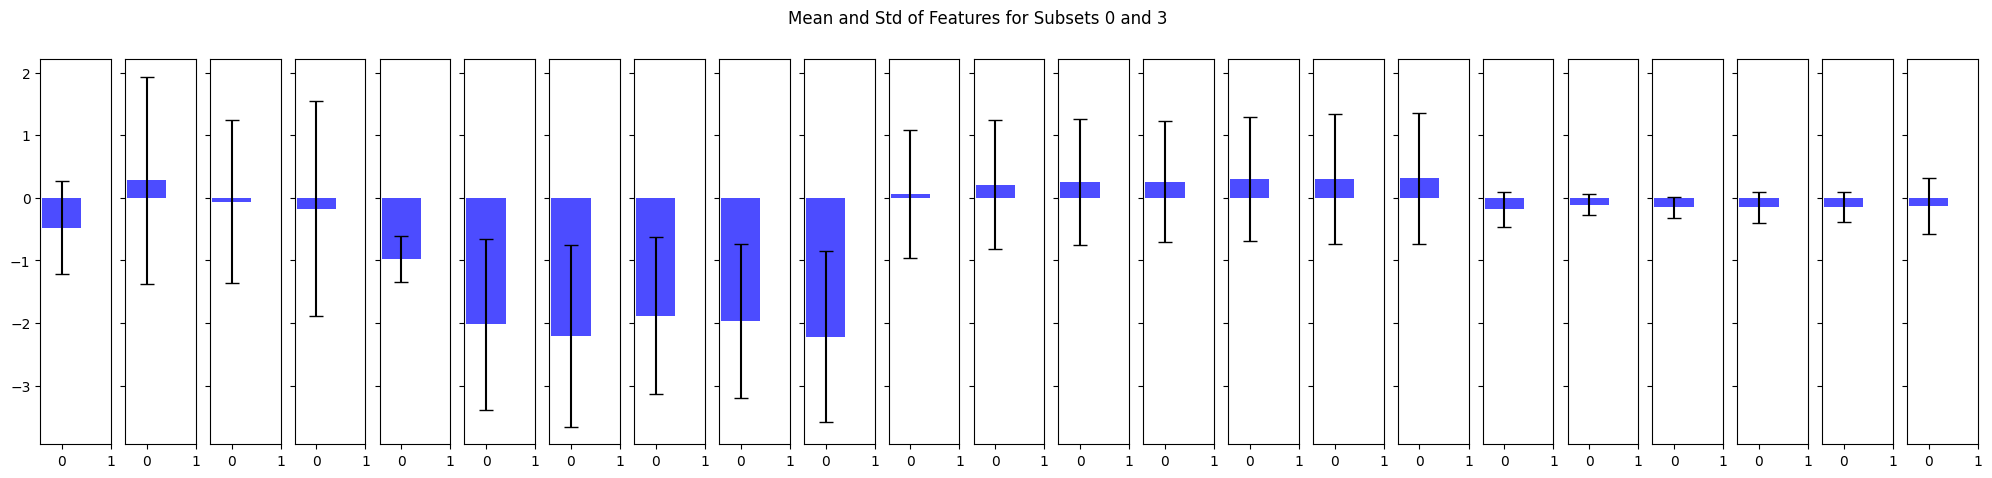

In [18]:
import matplotlib.pyplot as plt

# First subset
subset_0 = X_test_origin[S.argmax(dim=1) == 0]
mean_values_0 = subset_0.mean(axis=0)
std_values_0 = subset_0.std(axis=0)

# Second subset
subset_1 = X_test_origin[S.argmax(dim=1) == 3]
mean_values_1 = subset_1.mean(axis=0)
std_values_1 = subset_1.std(axis=0)

fig, axes = plt.subplots(1, len(mean_values_0), figsize=(25, 5), sharey=True)

for i in range(len(mean_values_0)):
    axes[i].bar(
        0, mean_values_0[i], yerr=std_values_0[i], capsize=5, color="blue", alpha=0.7
    )
    axes[i].bar(
        1, mean_values_1[i], yerr=std_values_1[i], capsize=5, color="green", alpha=0.7
    )
    axes[i].set_xticks([0, 1])
    # axes[i].set_xticklabels(['Subset 0', 'Subset 1'])
    # axes[i].set_title(f'Feature {i}')

fig.suptitle("Mean and Std of Features for Subsets 0 and 3")
plt.show()